In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
from math import log10, sqrt
import pydicom as dcm
import os
import pandas as pd
import csv
import tifffile
from pathlib import Path
from sklearn.metrics import confusion_matrix as cf


* Read Cover Image

In [22]:
def img_read(x):
    img=cv2.imread(x,0)
    return img
def watermark_read(x):
    wtr_img=cv2.imread(x,0)
    wtr_img=cv2.resize(wtr_img,(32,32))
    return wtr_img

* Random sequence generator

In [23]:
import random
def hcf(a,b):
    if(b%a==0):
        return a
    else:
        return hcf(b%a,a)
def randomseq(size):
    random.seed(size)
    
    num=[x for x in range(size)]
    h=len(num)
    for m in range(h):
        if m>2:
            r=hcf(m,h)
            if r==1:
                break 
    i=random.randint(0,size-1)    
    x=i
    res=[]
    while True:
        i=(i+m)%h
        if i==x:
            break
        res.append(i)
        
    res.append(x)
    return res

In [24]:
def embedding_epr(img,bstring):
    # bstring=''.join(format(ord(i), '08b') for i in txt)
    (row,col)=img.shape
    LL=img
    lrow,lcol=LL.shape
    l4x4=LL.reshape(-1,2,2)
    ustore=[]
    vstore=[]
    sstore=[]
    t=0
    for i in l4x4:
        u,s,v=np.linalg.svd(i)
        t+=abs(u[0][0]-u[1][0])
        ustore.append(u)
        vstore.append(v)
        sstore.append(s)
    t=t/len(ustore)
    seq=randomseq(len(ustore))
    k=0
    for i in seq:
        if k==len(bstring):
            break
        if bstring[k]=='0':
            if ustore[i][0][0]<=ustore[i][1][0]:
                ustore[i][0][0],ustore[i][1][0]=ustore[i][1][0],ustore[i][0][0]
            if ustore[i][0][0]-ustore[i][1][0]<t:
                ustore[i][0][0]+=t/2
                ustore[i][1][0]-=t/2
        else:
            if ustore[i][0][0]>ustore[i][1][0]:
                ustore[i][0][0],ustore[i][1][0]=ustore[i][1][0],ustore[i][0][0]
            if ustore[i][1][0]-ustore[i][0][0]<t:
                ustore[i][1][0]+=t/2
                ustore[i][0][0]-=t/2
        k+=1
    newll=[]
    for i in range(len(sstore)):
        u=ustore[i]
        v=vstore[i]
        s=sstore[i]
        temp=u@np.diag(s)@v
        newll.append(temp)
    newll=np.array(newll)
    newll=newll.ravel()
    newll=newll.reshape(lrow,lcol)
    return newll
def recover_epr(watermarked_img,length):
    dLL=watermarked_img
    dl2x2=dLL.reshape(-1,2,2)
    rec=''

    seq=randomseq(dl2x2.shape[0])
    k=0
    for i in seq:
        if k==length:
            break
        u,s,v=np.linalg.svd(dl2x2[i])
        if u[0][0]>u[1][0]:
            rec+='0'
        else:
            rec+='1'
        k+=1
    return rec

In [25]:

def calcRedundantBits(m):
	for i in range(m):
		if(2**i >= m + i + 1):
			return i

def posRedundantBits(data, r):
	j = 0
	k = 1
	m = len(data)
	res = ''
	for i in range(1, m + r+1):
		if(i == 2**j):
			res = res + '0'
			j += 1
		else:
			res = res + data[-1 * k]
			k += 1
	return res[::-1]


def calcParityBits(arr, r):
	n = len(arr)
	for i in range(r):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		arr = arr[:n-(2**i)] + str(val) + arr[n-(2**i)+1:]
	return arr


def detectError(arr, nr):
	n = len(arr)
	res = 0
	for i in range(nr):
		val = 0
		for j in range(1, n + 1):
			if(j & (2**i) == (2**i)):
				val = val ^ int(arr[-1 * j])
		res = res + val*(10**i)
	return int(str(res), 2)

def implementecc(bindata):
	output=''
	for i in range(0,len(bindata),8):
		data=bindata[i:i+8]
		m=len(data)
		r=calcRedundantBits(m)
		arr=posRedundantBits(data,r)
		arr=calcParityBits(arr,r)
		output+=str(arr)
	return output,r

def removeerror(outdata,r):
	output=''
	for i in range(0,len(outdata),12):
		data=outdata[i:i+12]
		pos=detectError(data,r)
		if pos==0:
			temp=data[0:4]+data[5:8]+data[9]
		else:
			pos=len(data)-pos+1
			if data[pos-1]=='0':
				data=data[0:pos-1]+'1'+data[pos:]
			else:
				data=data[0:pos-1]+'0'+data[pos:]
			temp=data[0:4]+data[5:8]+data[9]	
		output+=temp
	return output


In [26]:
from sklearn.metrics import mean_squared_error

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    try:
        max_pixel = 4096.0
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return psnr
    except:
        return -9999  #When MSE is Zero, i.e, no noise is present in the image
def norm_data(data):
    mean_data=np.mean(data)
    std_data=np.std(data,ddof=1)
    return (data-mean_data)/(std_data)
def ncc(data0,data1):
    c=(1.0/(data0.size-1))*np.sum(norm_data(data0)*norm_data(data1))
    return c

* Attacks

In [27]:
import random
def salt_pepper(img,p):
    new=img.copy()
    x,y=img.shape
    pixels=int(x*y*p)
    sp=[]
    for i in range(pixels):
        sp.append((random.randint(0,y-1),random.randint(0,x-1),random.choice([0,255])))
    for i,j,v in sp:
        new[i,j]=v
    return new
def gauss_noise(img,mean,variance):
    s=variance**2
    x,y=img.shape
    r=np.random.normal(mean,s,(y,x))
    return img+r
from skimage.metrics import structural_similarity

def ssim(name,name1):
    return structural_similarity(name,name1)
def medianfilter(img):
    im=img.copy()
    rows=im.shape[0]
    cols=im.shape[1]
    for i in range(1,rows-1):
        for j in range(1,cols-1):
            temp_array=[im[i][j],im[i-1][j],im[i+1][j],im[i][j-1],im[i][j+1],im[i-1][j-1],im[i-1][j+1],im[i+1][j-1],im[i+1][j+1]]
            temp_array.sort()
            # print(temp_array)
            im[i][j]=temp_array[4]
            temp_array=None
    return im
def crop(img,d):
    new=img.copy()
    x,y=img.shape
    x1=(x-d)//2
    y1=(y-d)//2
    new[y1:y1+d,x1:x1+d]=255
    return new


* Final Function

In [28]:
def umatrixwatermarking(cover,txt):
    bstring1=bin(int.from_bytes(txt.encode(),'big'))[2:]
    bstring=bstring1
    extra=8-len(bstring)%8
    for i in range(extra):
        bstring+='0'
    newbstring,r=implementecc(bstring)
    stego_epr=embedding_epr(cover,newbstring)
    return stego_epr,len(newbstring),r,extra,bstring1
def umatrixextraction(stego_epr,l,r,extra):
    decoded_epr=recover_epr(stego_epr,l)
    org_dec=removeerror(decoded_epr,r)
    org_dec=org_dec[0:-extra]
    input_string=int(org_dec,2)
    decoded_str=input_string.to_bytes((input_string.bit_length()+7)//8,'big').decode()
    return decoded_str,org_dec
    # return org_dec
    

In [29]:
def confmat(b,b2):
    s1=[]
    s2=[]
    for i in b:
        s1.append(i)
    for j in b2:
        s2.append(j)
    return cf(s1,s2)

* Decode

True

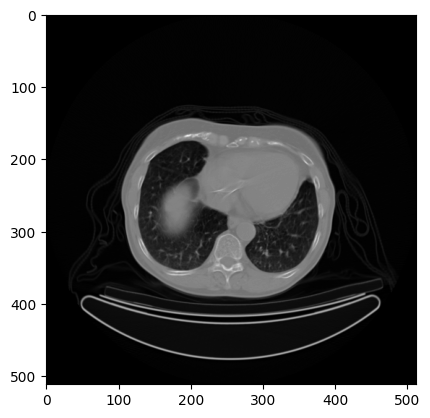

In [30]:
cover=tifffile.imread('../datasets/medical_image/tiff_images/ID_0069_AGE_0074_CONTRAST_0_CT.tif')
cover+=2048
txt=Path('epr.txt').read_text()
plt.imshow(cover,cmap='gray')
cv2.imwrite("./med1.tif",cover)

True

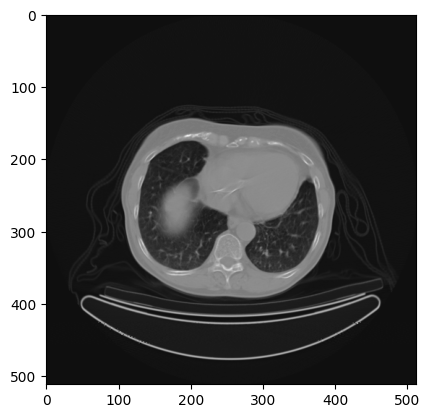

In [31]:
import tifffile
e2,l,r,ex,b=umatrixwatermarking(cover,txt)
e3=e2-2048
plt.imshow(e3,cmap='gray')
dec2,b2=umatrixextraction(e2,l,r,ex)
# print(dec2)
cv2.imwrite("./medstego.png",e2)
cv2.imwrite("./med2.png",cover)


In [32]:
PSNR(e2,cover)

53.06906674707828

In [33]:
s1=[]
s2=[]
for i in b:
    s1.append(i)
for j in b2:
    s2.append(j)
cf(s1,s2)

array([[476,   0],
       [  0, 387]], dtype=int64)

In [34]:
dec2

'Doctor: Jojo\nHospital Code: ABC_HOSPITAL_64\nImage: Brain Cancer\nPatient Name: Temp Roy\nCopyright: Swarnadeep'

In [35]:
cover2=img_read('./CoverImages/lena.tiff')
e3,l2,r2,ex2,b2=umatrixwatermarking(cover2,txt)
atk1=salt_pepper(e3,0.001)
atk2=gauss_noise(e3,0.001,0.001)
atk3=crop(e3,50)
atk4=medianfilter(e3)
cv2.imwrite('./medicalatk.jpg',e3)
atk5=img_read('./medicalatk.jpg')
fb1=umatrixextraction(atk1,l2,r2,ex2)
fb2=umatrixextraction(atk2,l2,r2,ex2)
fb3=umatrixextraction(atk3,l2,r2,ex2)
fb4=umatrixextraction(atk4,l2,r2,ex2)
fb5=umatrixextraction(atk5,l2,r2,ex2)

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xea in position 3: invalid continuation byte

***Salt & Peeper***

In [ ]:
confmat(b2,fb1)

array([[476,   0],
       [  0, 387]], dtype=int64)

***Gaussian Noise***

In [ ]:
confmat(b2,fb2)

array([[476,   0],
       [  0, 387]], dtype=int64)

***Crop 50 px.***

In [ ]:
confmat(b2,fb3)

array([[476,   0],
       [  0, 387]], dtype=int64)

***Median Filter***

In [ ]:
confmat(b2,fb4)

array([[327, 149],
       [164, 223]], dtype=int64)

***JPEG Compression***

In [ ]:
confmat(b2,fb5)

array([[476,   0],
       [  0, 387]], dtype=int64)